In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import joblib
import numpy as np

In [2]:
# Load datasets
profile_df = pd.read_csv('C:/Users/Bhavya Jha/OneDrive/Desktop/Projects/prediction_model/student_profile_data.csv')
engagement_df = pd.read_csv('C:/Users/Bhavya Jha/OneDrive/Desktop/Projects/prediction_model/course_engagement_data.csv')
historical_df = pd.read_csv('C:/Users/Bhavya Jha/OneDrive/Desktop/Projects/prediction_model/historical_data.csv')

In [3]:
# Merge the three dataframes on 'student_id'
merged_df = pd.merge(profile_df, engagement_df, on='student_id')
merged_df = pd.merge(merged_df, historical_df, on='student_id')

In [4]:
# Define thresholds for completion
course_completion_threshold = 3
average_quiz_score_threshold = 70
logins_per_week_threshold = 4

In [5]:
# Determine completion status
def determine_completion_status(row):
    if (row['courses_completed'] > course_completion_threshold and 
        row['avg_score_across_courses'] > average_quiz_score_threshold and 
        row['logins_per_week'] > logins_per_week_threshold):
        return 1  # Likely to complete
    else:
        return 0  # Likely to drop out

In [6]:
# Apply function to create the target variable
merged_df['completion_status'] = merged_df.apply(determine_completion_status, axis=1)


In [7]:
# Handle missing values
numerical_cols = ['logins_per_week', 'time_spent_on_platform (hrs)', 'avg_quiz_score', 
                  'courses_completed', 'courses_started', 'avg_score_across_courses']
categorical_cols = ['gender', 'major', 'region']

merged_df[numerical_cols] = merged_df[numerical_cols].fillna(merged_df[numerical_cols].mean())
merged_df[categorical_cols] = merged_df[categorical_cols].fillna(merged_df[categorical_cols].mode().iloc[0])

In [8]:
# One-Hot Encode categorical features
merged_df = pd.get_dummies(merged_df, columns=categorical_cols, drop_first=True)

In [9]:
# Define features and target variable
X = merged_df.drop(columns=['student_id', 'completion_status'])
y = merged_df['completion_status']

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [15]:
# Model evaluation: Random Forest with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=1)

In [16]:
# Best model and evaluation
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Best Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Best Random Forest Model Evaluation:
Accuracy: 0.9904761904761905

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        80
           1       1.00      0.96      0.98        25

    accuracy                           0.99       105
   macro avg       0.99      0.98      0.99       105
weighted avg       0.99      0.99      0.99       105



In [17]:
# Feature importance
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values(by='importance', ascending=False)


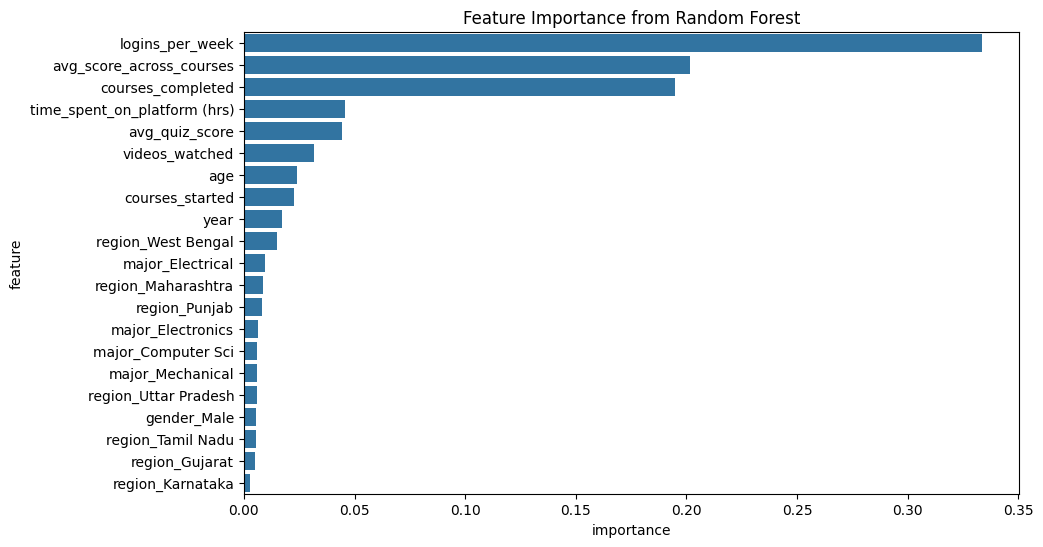

In [18]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

In [19]:
# Cross-validation evaluation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores:", cv_scores)
print("Mean Cross-Validation F1 Score:", cv_scores.mean())

# Save model
joblib.dump(best_model, 'student_completion_model.pkl')

Cross-Validation F1 Scores: [0.96551724 1.         1.         1.         1.        ]
Mean Cross-Validation F1 Score: 0.993103448275862


['student_completion_model.pkl']

In [20]:
# Predict completion status for all students and filter likely dropouts
merged_df['predicted_completion_status'] = best_model.predict(X)
dropout_students = merged_df[merged_df['predicted_completion_status'] == 0]
dropout_students.to_csv('likely_dropout_students.csv', index=False)

In [21]:
# MAP@K and NDCG@K functions
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k) if actual else 0.0

def mapk(actual_list, predicted_list, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual_list, predicted_list)])

def dcg_at_k(relevance_scores, k=10):
    relevance_scores = np.array(relevance_scores)[:k]
    return np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores) + 2)))

def ndcg_at_k(actual, predicted, k=10):
    ideal_dcg = dcg_at_k(sorted([1 if i in actual else 0 for i in actual], reverse=True), k)
    if ideal_dcg == 0:
        return 0.0
    relevance_scores = [1 if p in actual else 0 for p in predicted]
    dcg = dcg_at_k(relevance_scores, k)
    return dcg / ideal_dcg

In [22]:
# Example usage for MAP@3 and NDCG@3
actual_list = [[1, 2, 3], [1], [2, 3, 4], [1, 2], [3]]
predicted_list = [[1, 2, 4], [2], [1, 2, 3], [1, 3], [1, 2]]

print(f'MAP@3: {mapk(actual_list, predicted_list, k=3)}')
ndcg_scores = [ndcg_at_k(actual, predicted, k=3) for actual, predicted in zip(actual_list, predicted_list)]
print(f'NDCG@3: {np.mean(ndcg_scores)}')

MAP@3: 0.31111111111111106
NDCG@3: 0.38184582074626466
